# Definitions, function etc.. not to show

In [1]:
%load_ext autoreload
%autoreload 2

Currently, to run this tutorial, you'll have to clone the CLIMADA repo:

```
git clone https://github.com/CLIMADA-project/climada_python.git
cd climada_python
```

Then from within the repo folder:

```
mamba create -n climada_MCA "python==3.11.*"
git fetch
git checkout feature/MCDM
mamba env update -n climada_MCA -f requirements/env_climada.yml
mamba activate climada_MCA
python -m pip install ./

```

In [2]:
import json
import time
from io import StringIO
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
from climada.engine.option_appraisal.MCDM.criterion import Criterion
from climada.engine.option_appraisal.MCDM.mca_calc import MCA_Calc
from climada.entity import Exposures
from climada.hazard import Centroids, Hazard
from matplotlib.ticker import FuncFormatter

# Some compromise methods
from pyrepo_mcda.compromise_rankings import (
    copeland,
    dominance_directed_graph,
    rank_position_method,
)

# Some of the MCDM ranking methods if needed
from pyrepo_mcda.mcda_methods import (  # SPOTIS, ARAS, COCOSO, CODAS, COPRAS, CRADIS, EDAS, MABAC, MARCOS, MULTIMOORA, MULTIMOORA_RS, PROMETHEE_II, PROSA_C,, VMCM, WASPAS, VIKOR_SMAA
    AHP,
    SAW,
    TOPSIS,
    VIKOR,
)
from rasterio.mask import mask
from scipy.sparse import csr_matrix
from shapely.geometry import box, mapping


# Plotting utils
def human_format(num, pos):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return "%.2f%s" % (num, ["", "K", "M", "G", "T", "P"][magnitude])


def format_labels(input_string):
    string_with_spaces = input_string.replace("_", " ")
    formatted_string = string_with_spaces.capitalize()
    return formatted_string


formatter = FuncFormatter(human_format)


def save_impact_funcs_to_json(impact_funcs, filename):
    """
    Saves a list of climada.entity.ImpactFunc objects to a JSON file.

    This function handles the conversion of numpy arrays within the objects
    to standard Python lists, making them JSON-serializable.

    Args:
        impact_funcs (list): A list of ImpactFunc objects to save.
        filename (str): The name of the JSON file to create.
    """
    # List to hold the dictionaries of our impact functions
    impact_funcs_data = []

    # Iterate through each ImpactFunc object
    for impf in impact_funcs:
        # Create a dictionary from the object's attributes
        # Convert numpy arrays to lists for JSON serialization
        impf_dict = {
            "haz_type": impf.haz_type,
            "id": impf.id,
            "intensity": impf.intensity.tolist(),
            "mdd": impf.mdd.tolist(),
            "paa": impf.paa.tolist(),
            "intensity_unit": impf.intensity_unit,
            "name": impf.name,
        }
        impact_funcs_data.append(impf_dict)

    # Write the list of dictionaries to the JSON file
    try:
        with open(filename, "w") as f:
            json.dump(impact_funcs_data, f, indent=4)
        print(
            f"Successfully saved {len(impact_funcs)} impact functions to '{filename}'"
        )
    except IOError as e:
        print(f"An error occurred while writing to the file: {e}")


def load_impact_funcs_from_json(filename):
    """
    Loads a list of climada.entity.ImpactFunc objects from a JSON file.

    This function reads the data from the JSON file and converts the lists
    back into numpy arrays to properly reconstruct the ImpactFunc objects.

    Args:
        filename (str): The name of the JSON file to load from.

    Returns:
        list: A list of reconstructed ImpactFunc objects.
    """
    loaded_impact_funcs = []

    try:
        with open(filename, "r") as f:
            impact_funcs_data = json.load(f)

        # Iterate through the list of dictionaries from the file
        for impf_dict in impact_funcs_data:
            # Recreate the ImpactFunc object
            # Convert lists back to numpy arrays
            impf = ImpactFunc(
                haz_type=impf_dict["haz_type"],
                id=impf_dict["id"],
                intensity=np.array(impf_dict["intensity"]),
                mdd=np.array(impf_dict["mdd"]),
                paa=np.array(impf_dict["paa"]),
                intensity_unit=impf_dict["intensity_unit"],
                name=impf_dict["name"],
            )
            loaded_impact_funcs.append(impf)

        print(
            f"Successfully loaded {len(loaded_impact_funcs)} impact functions from '{filename}'"
        )
        return loaded_impact_funcs

    except FileNotFoundError:
        print(f"Error: The file '{filename}' was not found.")
        return []
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from '{filename}'. File may be corrupted.")
        return []


results_data = '{"date":{"0":1735689600000,"1":1735689600000,"2":1735689600000,"3":1735689600000,"4":1735689600000,"5":1735689600000,"6":1735689600000,"7":1735689600000,"8":1735689600000,"9":1735689600000,"10":1735689600000,"11":1735689600000,"12":1735689600000,"13":1735689600000,"14":1735689600000,"15":1735689600000,"16":1735689600000,"17":1735689600000,"18":1735689600000,"19":1735689600000,"20":1735689600000,"21":1735689600000,"22":1735689600000,"23":1735689600000,"24":1735689600000,"25":1735689600000,"26":1735689600000,"27":1735689600000,"28":1735689600000,"29":1735689600000,"30":1735689600000,"31":1735689600000,"32":1735689600000,"33":1735689600000,"34":1735689600000,"35":1735689600000,"36":1735689600000,"37":1735689600000,"38":1735689600000,"39":1735689600000,"40":1735689600000,"41":1735689600000,"42":1735689600000,"43":1735689600000,"44":1735689600000,"45":1735689600000,"46":1735689600000,"47":1735689600000,"48":1735689600000,"49":1735689600000,"50":1735689600000,"51":1735689600000,"52":1735689600000,"53":1735689600000,"54":1735689600000,"55":1735689600000,"56":1735689600000,"57":1735689600000,"58":1735689600000,"59":1735689600000},"group":{"0":"0","1":"0","2":"0","3":"0","4":"0","5":"0","6":"1","7":"1","8":"1","9":"1","10":"1","11":"1","12":"2","13":"2","14":"2","15":"2","16":"2","17":"2","18":"3","19":"3","20":"3","21":"3","22":"3","23":"3","24":"4","25":"4","26":"4","27":"4","28":"4","29":"4","30":"5","31":"5","32":"5","33":"5","34":"5","35":"5","36":"All","37":"All","38":"All","39":"All","40":"All","41":"All","42":"All","43":"All","44":"All","45":"All","46":"All","47":"All","48":"All","49":"All","50":"All","51":"All","52":"All","53":"All","54":"All","55":"All","56":"All","57":"All","58":"All","59":"All"},"measure":{"0":"All barriers","1":"Building code","2":"Early warning","3":"East Barrier","4":"Relocate","5":"no_measure","6":"All barriers","7":"Building code","8":"Early warning","9":"East Barrier","10":"Relocate","11":"no_measure","12":"All barriers","13":"Building code","14":"Early warning","15":"East Barrier","16":"Relocate","17":"no_measure","18":"All barriers","19":"Building code","20":"Early warning","21":"East Barrier","22":"Relocate","23":"no_measure","24":"All barriers","25":"Building code","26":"Early warning","27":"East Barrier","28":"Relocate","29":"no_measure","30":"All barriers","31":"Building code","32":"Early warning","33":"East Barrier","34":"Relocate","35":"no_measure","36":"All barriers","37":"All barriers","38":"All barriers","39":"All barriers","40":"Building code","41":"Building code","42":"Building code","43":"Building code","44":"Early warning","45":"Early warning","46":"Early warning","47":"Early warning","48":"East Barrier","49":"East Barrier","50":"East Barrier","51":"East Barrier","52":"Relocate","53":"Relocate","54":"Relocate","55":"Relocate","56":"no_measure","57":"no_measure","58":"no_measure","59":"no_measure"},"metric":{"0":"aai","1":"aai","2":"aai","3":"aai","4":"aai","5":"aai","6":"aai","7":"aai","8":"aai","9":"aai","10":"aai","11":"aai","12":"aai","13":"aai","14":"aai","15":"aai","16":"aai","17":"aai","18":"aai","19":"aai","20":"aai","21":"aai","22":"aai","23":"aai","24":"aai","25":"aai","26":"aai","27":"aai","28":"aai","29":"aai","30":"aai","31":"aai","32":"aai","33":"aai","34":"aai","35":"aai","36":"aai","37":"rp_100","38":"rp_30","39":"rp_5","40":"aai","41":"rp_100","42":"rp_30","43":"rp_5","44":"aai","45":"rp_100","46":"rp_30","47":"rp_5","48":"aai","49":"rp_100","50":"rp_30","51":"rp_5","52":"aai","53":"rp_100","54":"rp_30","55":"rp_5","56":"aai","57":"rp_100","58":"rp_30","59":"rp_5"},"averted risk_euros":{"0":7679.1029629251,"1":64860.1737021822,"2":6486.0173702182,"3":-0.181868427,"4":43206.0702493758,"5":0.0,"6":0.0,"7":48.2000492655,"8":4.8200049266,"9":0.0,"10":48.2000492655,"11":0.0,"12":0.0,"13":0.0,"14":0.0,"15":0.0,"16":0.0,"17":0.0,"18":89805.9133178109,"19":343153.2584883361,"20":35032.8011055177,"21":47221.3683556874,"22":250725.1805320082,"23":0.0,"24":14192.7159457517,"25":28406.6010875431,"26":2860.9396222663,"27":13848.1752672509,"28":26241.3981952773,"29":0.0,"30":0.0,"31":38744.4156091639,"32":3904.0326636952,"33":0.0,"34":38972.7696197125,"35":0.0,"36":111677.7322264878,"37":3431087.8684652653,"38":2128514.367785336,"39":144913.1171650226,"40":475212.6489364907,"41":9894656.2411307693,"42":5824757.5587709472,"43":1186273.7938989394,"44":48288.610766624,"45":1048084.6024227198,"46":592697.0251786448,"47":118882.5075498063,"48":61069.3617545113,"49":2153317.4238455659,"50":1070094.6107289949,"51":80647.1746953737,"52":358855.0857286445,"53":7699943.1059655938,"54":4548726.9551050346,"55":869000.4009093259,"56":0.0,"57":0.0,"58":0.0,"59":0.0},"averted risk_people":{"0":70.69647789,"1":114.9856977463,"2":11.4985713959,"3":52.4013290405,"4":89.5322113037,"5":0.0,"6":30.6654162407,"7":134.0327997208,"8":13.4032850266,"9":23.7188091278,"10":120.139585495,"11":0.0,"12":0.0,"13":0.0,"14":0.0,"15":0.0,"16":0.0,"17":0.0,"18":0.0,"19":0.0,"20":0.0,"21":0.0,"22":0.0,"23":0.0,"24":0.0,"25":0.0,"26":0.0,"27":0.0,"28":0.0,"29":0.0,"30":0.0,"31":0.0,"32":0.0,"33":0.0,"34":0.0,"35":0.0,"36":289.5272917747,"37":162.9707317352,"38":162.9707317352,"39":162.9707317352,"40":786.0813115931,"41":538.7813261165,"42":517.5732216384,"43":509.7414209292,"44":77.3589959145,"45":50.8647582531,"46":50.8647582531,"47":50.8647582531,"48":197.6397676468,"49":126.2344665527,"50":126.2344665527,"51":126.2344665527,"52":504.9226121902,"53":349.5358133316,"54":349.5358133316,"55":349.5358133316,"56":0.0,"57":0.0,"58":0.0,"59":0.0},"benefit minus cost_euros":{"0":-63992320.897037074,"1":-49935139.8262978196,"2":-193513.9826297818,"3":-28800000.1818684265,"4":-7999956793.9297504425,"5":0.0,"6":-64000000.0,"7":-49999951.7999507338,"8":-199995.1799950734,"9":-28800000.0,"10":-7999999951.7999505997,"11":0.0,"12":-64000000.0,"13":-50000000.0,"14":-200000.0,"15":-28800000.0,"16":-8000000000.0,"17":0.0,"18":-63910194.0866821855,"19":-49656846.7415116653,"20":-164967.1988944823,"21":-28752778.6316443123,"22":-7999749274.8194675446,"23":0.0,"24":-63985807.2840542495,"25":-49971593.3989124596,"26":-197139.0603777337,"27":-28786151.8247327507,"28":-7999973758.6018047333,"29":0.0,"30":-64000000.0,"31":-49961255.584390834,"32":-196095.9673363048,"33":-28800000.0,"34":-7999961027.2303800583,"35":0.0,"36":-63888322.267773509,"37":-60568912.1315347329,"38":-61871485.6322146654,"39":-63855086.8828349784,"40":-49524787.3510635123,"41":-40105343.7588692307,"42":-44175242.4412290528,"43":-48813726.2061010599,"44":-151711.389233376,"45":848084.6024227198,"46":392697.0251786448,"47":-81117.4924501937,"48":-28738930.6382454894,"49":-26646682.5761544332,"50":-27729905.389271006,"51":-28719352.8253046274,"52":-7999641144.9142713547,"53":-7992300056.8940343857,"54":-7995451273.0448951721,"55":-7999130999.5990905762,"56":0.0,"57":0.0,"58":0.0,"59":0.0},"benefit minus cost_people":{"0":-63999929.30352211,"1":0.0,"2":-199988.5014286041,"3":-28799947.5986709595,"4":-7999999910.4677886963,"5":0.0,"6":-63999969.3345837593,"7":0.0,"8":-199986.5967149734,"9":-28799976.2811908722,"10":-7999999879.860414505,"11":0.0,"12":-64000000.0,"13":0.0,"14":-200000.0,"15":-28800000.0,"16":-8000000000.0,"17":0.0,"18":0.0,"19":0.0,"20":0.0,"21":0.0,"22":0.0,"23":0.0,"24":0.0,"25":0.0,"26":0.0,"27":0.0,"28":0.0,"29":0.0,"30":0.0,"31":0.0,"32":0.0,"33":0.0,"34":0.0,"35":0.0,"36":-63999710.4727082253,"37":-63999837.0292682648,"38":-63999837.0292682648,"39":-63999837.0292682648,"40":12.4914807177,"41":30.133837284,"42":8.925732806,"43":1.0939320968,"44":-199922.6410040855,"45":-199949.1352417469,"46":-199949.1352417469,"47":-199949.1352417469,"48":-28799802.3602323532,"49":-28799873.7655334473,"50":-28799873.7655334473,"51":-28799873.7655334473,"52":-7999999495.0773878098,"53":-7999999650.4641866684,"54":-7999999650.4641866684,"55":-7999999650.4641866684,"56":0.0,"57":0.0,"58":0.0,"59":0.0},"cost\\/benefit ratio_euros":{"0":8334.3067945557,"1":770.8890856442,"2":30.8355634258,"3":-158356238.4940609038,"4":185159.1675388615,"5":0.0,"6":0.0,"7":1037343.338065353,"8":41493.7335226141,"9":0.0,"10":165974934.0904564857,"11":0.0,"12":0.0,"13":0.0,"14":0.0,"15":0.0,"16":0.0,"17":0.0,"18":712.6479497348,"19":145.7074900593,"20":5.7089354459,"21":609.8933809598,"22":31907.4453671744,"23":0.0,"24":4509.3553795218,"25":1760.1542629444,"26":69.9071027027,"27":2079.6963819564,"28":304861.8042555281,"29":0.0,"30":0.0,"31":1290.5085601078,"32":51.2290795771,"33":0.0,"34":205271.5287638572,"35":0.0,"36":573.0775394884,"37":18.6529760978,"38":30.0679201271,"39":441.6439398451,"40":105.216054564,"41":5.0532326522,"42":8.5840482622,"43":42.148785767,"44":4.1417633853,"45":0.1908242899,"46":0.3374405329,"47":1.6823332896,"48":471.5949073739,"49":13.3747118196,"50":26.9135081247,"51":357.1110842852,"52":22293.1214246448,"53":1038.9687157301,"54":1758.733834534,"55":9205.97964239,"56":0.0,"57":0.0,"58":0.0,"59":0.0},"cost\\/benefit ratio_people":{"0":905278.4793546203,"1":434836.6882142867,"2":17393.4650761716,"3":549604.3807920596,"4":89353316.3484862447,"5":0.0,"6":2087041.6203603919,"7":373043.0171134751,"8":14921.7150574523,"9":1214226.2221013138,"10":66589209.2688572779,"11":0.0,"12":0.0,"13":0.0,"14":0.0,"15":0.0,"16":0.0,"17":0.0,"18":0.0,"19":0.0,"20":0.0,"21":0.0,"22":0.0,"23":0.0,"24":0.0,"25":0.0,"26":0.0,"27":0.0,"28":0.0,"29":0.0,"30":0.0,"31":0.0,"32":0.0,"33":0.0,"34":0.0,"35":0.0,"36":221049.9728978626,"37":392708.5515206353,"38":392708.5515206353,"39":392708.5515206353,"40":63606.6514527248,"41":92802.028534285,"42":96604.6887853253,"43":98088.948527769,"44":2585.34896473,"45":3931.995488995,"46":3931.995488995,"47":3931.995488995,"48":145719.6612954419,"49":228146.8824361754,"50":228146.8824361754,"51":228146.8824361754,"52":15844012.1453418508,"53":22887497.346117191,"54":22887497.346117191,"55":22887497.346117191,"56":0.0,"57":0.0,"58":0.0,"59":0.0},"cumulated measure benefit_euros":{"0":7679.1029629251,"1":64860.1737021822,"2":6486.0173702182,"3":-0.181868427,"4":43206.0702493758,"5":0.0,"6":0.0,"7":48.2000492655,"8":4.8200049266,"9":0.0,"10":48.2000492655,"11":0.0,"12":0.0,"13":0.0,"14":0.0,"15":0.0,"16":0.0,"17":0.0,"18":89805.9133178109,"19":343153.2584883361,"20":35032.8011055177,"21":47221.3683556874,"22":250725.1805320082,"23":0.0,"24":14192.7159457517,"25":28406.6010875431,"26":2860.9396222663,"27":13848.1752672509,"28":26241.3981952773,"29":0.0,"30":0.0,"31":38744.4156091639,"32":3904.0326636952,"33":0.0,"34":38972.7696197125,"35":0.0,"36":111677.7322264878,"37":3431087.8684652653,"38":2128514.367785336,"39":144913.1171650226,"40":475212.6489364907,"41":9894656.2411307693,"42":5824757.5587709472,"43":1186273.7938989394,"44":48288.610766624,"45":1048084.6024227198,"46":592697.0251786448,"47":118882.5075498063,"48":61069.3617545113,"49":2153317.4238455659,"50":1070094.6107289949,"51":80647.1746953737,"52":358855.0857286445,"53":7699943.1059655938,"54":4548726.9551050346,"55":869000.4009093259,"56":0.0,"57":0.0,"58":0.0,"59":0.0},"cumulated measure benefit_people":{"0":70.69647789,"1":0.0,"2":11.4985713959,"3":52.4013290405,"4":89.5322113037,"5":0.0,"6":30.6654162407,"7":0.0,"8":13.4032850266,"9":23.7188091278,"10":120.139585495,"11":0.0,"12":0.0,"13":0.0,"14":0.0,"15":0.0,"16":0.0,"17":0.0,"18":0.0,"19":0.0,"20":0.0,"21":0.0,"22":0.0,"23":0.0,"24":0.0,"25":0.0,"26":0.0,"27":0.0,"28":0.0,"29":0.0,"30":0.0,"31":0.0,"32":0.0,"33":0.0,"34":0.0,"35":0.0,"36":289.5272917747,"37":162.9707317352,"38":162.9707317352,"39":162.9707317352,"40":0.0,"41":0.0,"42":0.0,"43":0.0,"44":77.3589959145,"45":50.8647582531,"46":50.8647582531,"47":50.8647582531,"48":197.6397676468,"49":126.2344665527,"50":126.2344665527,"51":126.2344665527,"52":504.9226121902,"53":349.5358133316,"54":349.5358133316,"55":349.5358133316,"56":0.0,"57":0.0,"58":0.0,"59":0.0},"cumulated measure cost_euros":{"0":64000000.0,"1":50000000.0,"2":200000.0,"3":28800000.0,"4":8000000000.0,"5":0.0,"6":64000000.0,"7":50000000.0,"8":200000.0,"9":28800000.0,"10":8000000000.0,"11":0.0,"12":64000000.0,"13":50000000.0,"14":200000.0,"15":28800000.0,"16":8000000000.0,"17":0.0,"18":64000000.0,"19":50000000.0,"20":200000.0,"21":28800000.0,"22":8000000000.0,"23":0.0,"24":64000000.0,"25":50000000.0,"26":200000.0,"27":28800000.0,"28":8000000000.0,"29":0.0,"30":64000000.0,"31":50000000.0,"32":200000.0,"33":28800000.0,"34":8000000000.0,"35":0.0,"36":64000000.0,"37":64000000.0,"38":64000000.0,"39":64000000.0,"40":50000000.0,"41":50000000.0,"42":50000000.0,"43":50000000.0,"44":200000.0,"45":200000.0,"46":200000.0,"47":200000.0,"48":28800000.0,"49":28800000.0,"50":28800000.0,"51":28800000.0,"52":8000000000.0,"53":8000000000.0,"54":8000000000.0,"55":8000000000.0,"56":0.0,"57":0.0,"58":0.0,"59":0.0},"cumulated measure cost_people":{"0":64000000.0,"1":0.0,"2":200000.0,"3":28800000.0,"4":8000000000.0,"5":0.0,"6":64000000.0,"7":0.0,"8":200000.0,"9":28800000.0,"10":8000000000.0,"11":0.0,"12":64000000.0,"13":0.0,"14":200000.0,"15":28800000.0,"16":8000000000.0,"17":0.0,"18":0.0,"19":0.0,"20":0.0,"21":0.0,"22":0.0,"23":0.0,"24":0.0,"25":0.0,"26":0.0,"27":0.0,"28":0.0,"29":0.0,"30":0.0,"31":0.0,"32":0.0,"33":0.0,"34":0.0,"35":0.0,"36":64000000.0,"37":64000000.0,"38":64000000.0,"39":64000000.0,"40":0.0,"41":0.0,"42":0.0,"43":0.0,"44":200000.0,"45":200000.0,"46":200000.0,"47":200000.0,"48":28800000.0,"49":28800000.0,"50":28800000.0,"51":28800000.0,"52":8000000000.0,"53":8000000000.0,"54":8000000000.0,"55":8000000000.0,"56":0.0,"57":0.0,"58":0.0,"59":0.0},"measure net cost_euros":{"0":64000000.0,"1":50000000.0,"2":200000.0,"3":28800000.0,"4":8000000000.0,"5":0.0,"6":64000000.0,"7":50000000.0,"8":200000.0,"9":28800000.0,"10":8000000000.0,"11":0.0,"12":64000000.0,"13":50000000.0,"14":200000.0,"15":28800000.0,"16":8000000000.0,"17":0.0,"18":64000000.0,"19":50000000.0,"20":200000.0,"21":28800000.0,"22":8000000000.0,"23":0.0,"24":64000000.0,"25":50000000.0,"26":200000.0,"27":28800000.0,"28":8000000000.0,"29":0.0,"30":64000000.0,"31":50000000.0,"32":200000.0,"33":28800000.0,"34":8000000000.0,"35":0.0,"36":64000000.0,"37":64000000.0,"38":64000000.0,"39":64000000.0,"40":50000000.0,"41":50000000.0,"42":50000000.0,"43":50000000.0,"44":200000.0,"45":200000.0,"46":200000.0,"47":200000.0,"48":28800000.0,"49":28800000.0,"50":28800000.0,"51":28800000.0,"52":8000000000.0,"53":8000000000.0,"54":8000000000.0,"55":8000000000.0,"56":0.0,"57":0.0,"58":0.0,"59":0.0},"measure net cost_people":{"0":64000000.0,"1":0.0,"2":200000.0,"3":28800000.0,"4":8000000000.0,"5":0.0,"6":64000000.0,"7":0.0,"8":200000.0,"9":28800000.0,"10":8000000000.0,"11":0.0,"12":64000000.0,"13":0.0,"14":200000.0,"15":28800000.0,"16":8000000000.0,"17":0.0,"18":0.0,"19":0.0,"20":0.0,"21":0.0,"22":0.0,"23":0.0,"24":0.0,"25":0.0,"26":0.0,"27":0.0,"28":0.0,"29":0.0,"30":0.0,"31":0.0,"32":0.0,"33":0.0,"34":0.0,"35":0.0,"36":64000000.0,"37":64000000.0,"38":64000000.0,"39":64000000.0,"40":0.0,"41":0.0,"42":0.0,"43":0.0,"44":200000.0,"45":200000.0,"46":200000.0,"47":200000.0,"48":28800000.0,"49":28800000.0,"50":28800000.0,"51":28800000.0,"52":8000000000.0,"53":8000000000.0,"54":8000000000.0,"55":8000000000.0,"56":0.0,"57":0.0,"58":0.0,"59":0.0},"reference risk_euros":{"0":64860.1737021822,"1":64860.1737021822,"2":64860.1737021822,"3":64860.1737021822,"4":64860.1737021822,"5":64860.1737021822,"6":48.2000492655,"7":48.2000492655,"8":48.2000492655,"9":48.2000492655,"10":48.2000492655,"11":48.2000492655,"12":0.0,"13":0.0,"14":0.0,"15":0.0,"16":0.0,"17":0.0,"18":350328.0110551771,"19":350328.0110551771,"20":350328.0110551771,"21":350328.0110551771,"22":350328.0110551771,"23":350328.0110551771,"24":28609.3962226633,"25":28609.3962226633,"26":28609.3962226633,"27":28609.3962226633,"28":28609.3962226633,"29":28609.3962226633,"30":39040.3266369518,"31":39040.3266369518,"32":39040.3266369518,"33":39040.3266369518,"34":39040.3266369518,"35":39040.3266369518,"36":482886.1076662398,"37":10480846.0242272019,"38":5926970.2517864509,"39":1188825.0754980613,"40":482886.1076662398,"41":10480846.0242272019,"42":5926970.2517864509,"43":1188825.0754980613,"44":482886.1076662398,"45":10480846.0242272019,"46":5926970.2517864509,"47":1188825.0754980613,"48":482886.1076662398,"49":10480846.0242272019,"50":5926970.2517864509,"51":1188825.0754980613,"52":482886.1076662398,"53":10480846.0242272019,"54":5926970.2517864509,"55":1188825.0754980613,"56":482886.1076662398,"57":10480846.0242272019,"58":5926970.2517864509,"59":1188825.0754980613},"reference risk_people":{"0":114.9856977463,"1":0.0,"2":114.9856977463,"3":114.9856977463,"4":114.9856977463,"5":114.9856977463,"6":134.0327997208,"7":0.0,"8":134.0327997208,"9":134.0327997208,"10":134.0327997208,"11":134.0327997208,"12":0.0,"13":0.0,"14":0.0,"15":0.0,"16":0.0,"17":0.0,"18":0.0,"19":0.0,"20":0.0,"21":0.0,"22":0.0,"23":0.0,"24":0.0,"25":0.0,"26":0.0,"27":0.0,"28":0.0,"29":0.0,"30":0.0,"31":0.0,"32":0.0,"33":0.0,"34":0.0,"35":0.0,"36":773.5898308754,"37":508.6474888325,"38":508.6474888325,"39":508.6474888325,"40":0.0,"41":0.0,"42":0.0,"43":0.0,"44":773.5898308754,"45":508.6474888325,"46":508.6474888325,"47":508.6474888325,"48":773.5898308754,"49":508.6474888325,"50":508.6474888325,"51":508.6474888325,"52":773.5898308754,"53":508.6474888325,"54":508.6474888325,"55":508.6474888325,"56":773.5898308754,"57":508.6474888325,"58":508.6474888325,"59":508.6474888325},"risk_euros":{"0":57181.070739257,"1":0.0,"2":58374.156331964,"3":64860.3555706092,"4":21654.1034528063,"5":64860.1737021822,"6":48.2000492655,"7":0.0,"8":43.380044339,"9":48.2000492655,"10":0.0,"11":48.2000492655,"12":0.0,"13":0.0,"14":0.0,"15":0.0,"16":0.0,"17":0.0,"18":260522.0977373662,"19":7174.752566841,"20":315295.2099496594,"21":303106.6426994898,"22":99602.830523169,"23":350328.0110551771,"24":14416.6802769115,"25":202.7951351202,"26":25748.4566003969,"27":14761.2209554123,"28":2367.9980273859,"29":28609.3962226633,"30":39040.3266369518,"31":295.9110277879,"32":35136.2939732566,"33":39040.3266369518,"34":67.5570172393,"35":39040.3266369518,"36":371208.375439752,"37":7049758.1557619367,"38":3798455.8840011149,"39":1043911.9583330386,"40":7673.4587297491,"41":586189.7830964327,"42":102212.6930155039,"43":2551.2815991219,"44":434597.4968996159,"45":9432761.4218044821,"46":5334273.226607806,"47":1069942.567948255,"48":421816.7459117286,"49":8327528.6003816361,"50":4856875.6410574559,"51":1108177.9008026875,"52":124031.0219375954,"53":2780902.9182616081,"54":1378243.2966814162,"55":319824.6745887353,"56":482886.1076662398,"57":10480846.0242272019,"58":5926970.2517864509,"59":1188825.0754980613},"risk_people":{"0":44.2892198563,"1":114.9856977463,"2":103.4871263504,"3":62.5843687057,"4":25.4534864426,"5":114.9856977463,"6":103.3673834801,"7":134.0327997208,"8":120.6295146942,"9":110.313990593,"10":13.8932142258,"11":134.0327997208,"12":0.0,"13":0.0,"14":0.0,"15":0.0,"16":0.0,"17":0.0,"18":0.0,"19":0.0,"20":0.0,"21":0.0,"22":0.0,"23":0.0,"24":0.0,"25":0.0,"26":0.0,"27":0.0,"28":0.0,"29":0.0,"30":0.0,"31":0.0,"32":0.0,"33":0.0,"34":0.0,"35":0.0,"36":484.0625391006,"37":345.6767570972,"38":345.6767570972,"39":345.6767570972,"40":773.5898308754,"41":508.6474888325,"42":508.6474888325,"43":508.6474888325,"44":696.2308349609,"45":457.7827305794,"46":457.7827305794,"47":457.7827305794,"48":575.9500632286,"49":382.4130222797,"50":382.4130222797,"51":382.4130222797,"52":268.6672186852,"53":159.1116755009,"54":159.1116755009,"55":159.1116755009,"56":773.5898308754,"57":508.6474888325,"58":508.6474888325,"59":508.6474888325}}'

In [3]:
results = pd.read_json(StringIO(results_data))

# Some filtering
df = results.loc[results["measure"] != "no_measure"]
df = df.drop(["date"], axis=1)
df = df.rename_axis("criteria", axis=1)

# Avoid some problems with some mcdm methods not liking 0
df["measure net cost_euros"] = df["measure net cost_euros"] + 1

# GA Workshop

## Defining objects

In [ ]:
# Heres how to create a list of criteria at the moment (probably will change or contains more data)

criteria = [
    Criterion(name="Cost", column_name="measure net cost_euros", obj_maximise=False),
    Criterion(
        name="Averted costs", column_name="averted risk_euros", obj_maximise=True
    ),
    Criterion(
        name="Protected people", column_name="averted risk_people", obj_maximise=True
    ),
    Criterion(
        name="Cost benefit", column_name="cost/benefit ratio_euros", obj_maximise=False
    ),
    Criterion(
        name="People protection cost",
        column_name="cost/benefit ratio_people",
        obj_maximise=False,
    ),
    Criterion(name="Residual damages", column_name="risk_euros", obj_maximise=False),
    Criterion(
        name="People not protected", column_name="risk_people", obj_maximise=False
    ),
]

In [20]:
# Same, the following will probably change, but was easier to manipulate than victor's code.
mca = MCA_Calc(
    risk_metrics=df,
    metrics_col="metric",
    groups_col="group",
    criteria=criteria,
    groups_weights={"0": 5, "1": 5, "2": 1, "3": 1, "4": 1, "5": 1, "All": 5},
    metrics_weights={
        "aai": 5,
        "rp_5": 1,
        "rp_30": 2,
        "rp_100": 3,
    },
    criteria_weights={
        "measure net cost_euros": 5,
        "averted risk_euros": 5,
        "averted risk_people": 5,
        "cost/benefit ratio_euros": 5,
        "cost/benefit ratio_people": 5,
        "risk_euros": 5,
        "risk_people": 5,
    },
    #    constraints = ["`measure net cost` > 10"]
)

## Show simple Averted risk and CB

In [40]:
mca.risk_metrics.loc[
    (mca.risk_metrics["group"] == "All") & (mca.risk_metrics["metric"] == "aai"),
    "benefit/cost ratio_euros",
] = (
    1
    / mca.risk_metrics.loc[
        (mca.risk_metrics["group"] == "All") & (mca.risk_metrics["metric"] == "aai"),
        "cost/benefit ratio_euros",
    ]
)
# mca.risk_metrics.loc[(mca.risk_metrics["group"]=="All") & (mca.risk_metrics["metric"]=="aai"),"benefit/cost ratio_people"] = 1/ mca.risk_metrics.loc[(mca.risk_metrics["group"]=="All") & (mca.risk_metrics["metric"]=="aai"),"cost/benefit ratio_people"]
mca.risk_metrics.loc[
    (mca.risk_metrics["group"] == "All") & (mca.risk_metrics["metric"] == "aai")
]

criteria,group,measure,metric,averted risk_euros,averted risk_people,benefit minus cost_euros,benefit minus cost_people,cost/benefit ratio_euros,cost/benefit ratio_people,cumulated measure benefit_euros,...,cumulated measure cost_euros,cumulated measure cost_people,measure net cost_euros,measure net cost_people,reference risk_euros,reference risk_people,risk_euros,risk_people,benefit/cost ratio_euros,benefit/cost ratio_people
36,All,All barriers,aai,111677.732226,289.527292,-6.388832e+07,-6.399971e+07,573.077539,2.210500e+05,111677.732226,...,64000000,64000000,64000001,64000000,482886.107666,773.589831,371208.375440,484.062539,0.001745,4.523864e-06
40,All,Building code,aai,475212.648936,786.081312,-4.952479e+07,1.249148e+01,105.216055,6.360665e+04,475212.648936,...,50000000,0,50000001,0,482886.107666,0.000000,7673.458730,773.589831,0.009504,1.572163e-05
44,All,Early warning,aai,48288.610767,77.358996,-1.517114e+05,-1.999226e+05,4.141763,2.585349e+03,48288.610767,...,200000,200000,200001,200000,482886.107666,773.589831,434597.496900,696.230835,0.241443,3.867950e-04
48,All,East Barrier,aai,61069.361755,197.639768,-2.873893e+07,-2.879980e+07,471.594907,1.457197e+05,61069.361755,...,28800000,28800000,28800001,28800000,482886.107666,773.589831,421816.745912,575.950063,0.002120,6.862492e-06
52,All,Relocate,aai,358855.085729,504.922612,-7.999641e+09,-7.999999e+09,22293.121425,1.584401e+07,358855.085729,...,8000000000,8000000000,8000000001,8000000000,482886.107666,773.589831,124031.021938,268.667219,0.000045,6.311533e-08


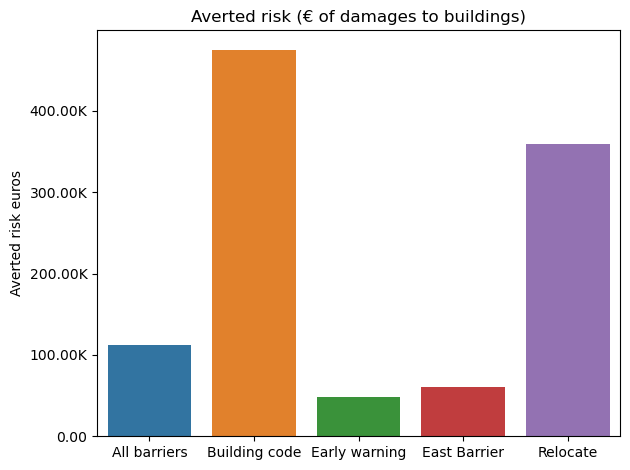

In [41]:
ax = sns.barplot(
    mca.risk_metrics.loc[
        (mca.risk_metrics["group"] == "All") & (mca.risk_metrics["metric"] == "aai")
    ],
    x="measure",
    hue="measure",
    y="averted risk_euros",
)

# ax.tick_params(axis="x", labelrotation=90)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel("")

# Iterate through the axes in the first column and set the new label
ax.set_ylabel(format_labels((ax.get_ylabel())))
plt.title("Averted risk (€ of damages to buildings)")
plt.tight_layout()

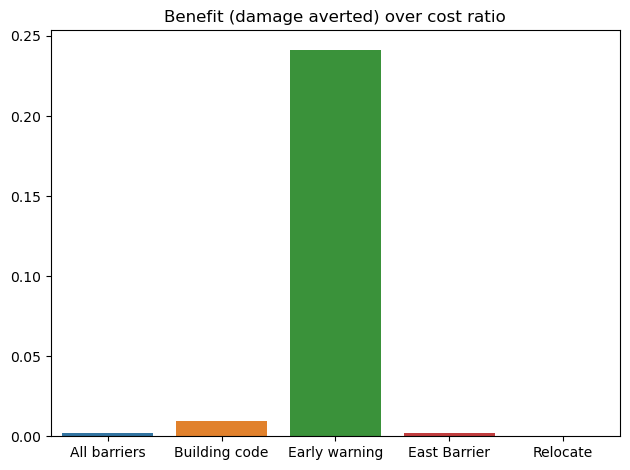

In [42]:
ax = sns.barplot(
    mca.risk_metrics.loc[
        (mca.risk_metrics["group"] == "All") & (mca.risk_metrics["metric"] == "aai")
    ],
    x="measure",
    hue="measure",
    y="benefit/cost ratio_euros",
)

# ax.tick_params(axis="x", labelrotation=90)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel("")
ax.set_ylabel("")

# Iterate through the axes in the first column and set the new label
ax.set_ylabel(format_labels((ax.get_ylabel())))
plt.title("Benefit (damage averted) over cost ratio")
plt.tight_layout()

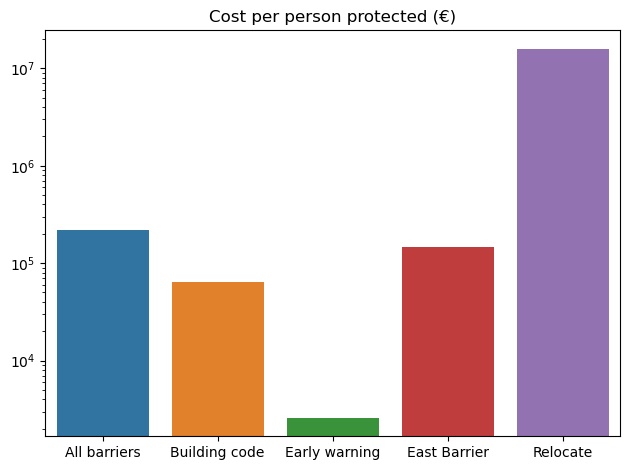

In [46]:
ax = sns.barplot(
    mca.risk_metrics.loc[
        (mca.risk_metrics["group"] == "All") & (mca.risk_metrics["metric"] == "aai")
    ],
    x="measure",
    hue="measure",
    y="cost/benefit ratio_people",
)

# ax.tick_params(axis="x", labelrotation=90)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_yscale("log")
# Iterate through the axes in the first column and set the new label
ax.set_ylabel(format_labels((ax.get_ylabel())))
plt.title("Cost per person protected (€)")
plt.tight_layout()

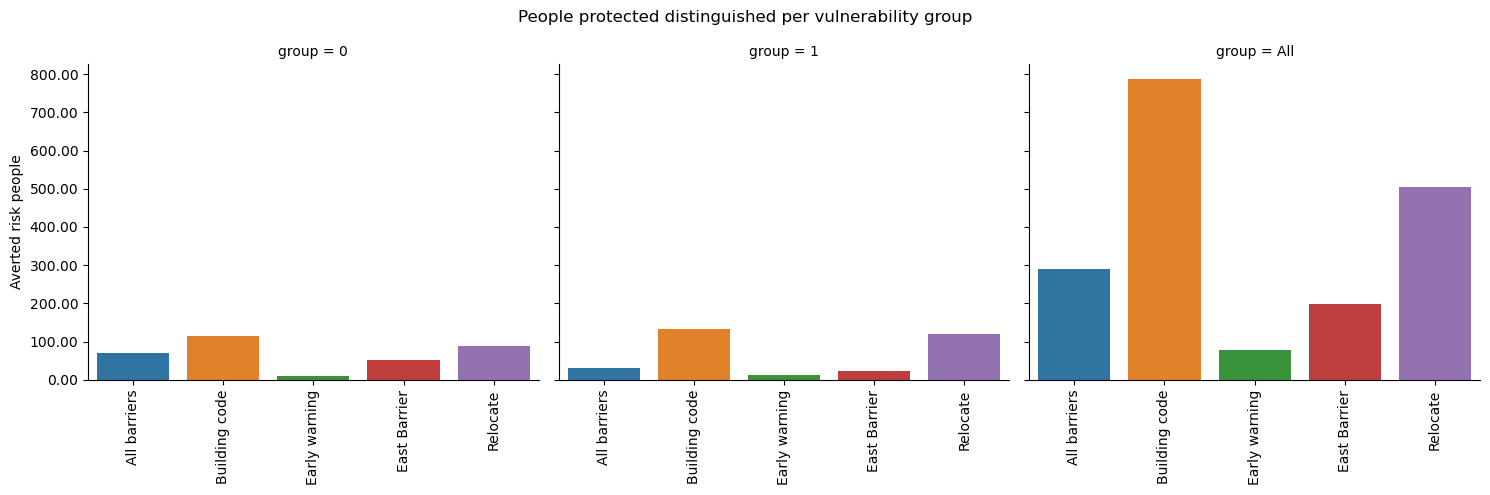

In [49]:
grid = sns.catplot(
    mca.risk_metrics.loc[
        (mca.risk_metrics["metric"] == "aai")
        & (mca.risk_metrics["group"].isin(["0", "1", "All"]))
    ],
    kind="bar",
    x="measure",
    y="averted risk_people",
    hue="measure",
    col="group",
    # col_order=["aai","rp_5","rp_30","rp_100"],
    col_wrap=3,
    sharey=True,
)
grid.tick_params(axis="x", labelrotation=90)
for ax in grid.axes.flatten():
    ax.yaxis.set_major_formatter(formatter)
    ax.set_xlabel("")

# Iterate through the axes in the first column and set the new label
for ax in grid.axes[::2]:
    ax.set_ylabel(format_labels((ax.get_ylabel())))

plt.suptitle("People protected distinguished per vulnerability group")
grid.tight_layout()

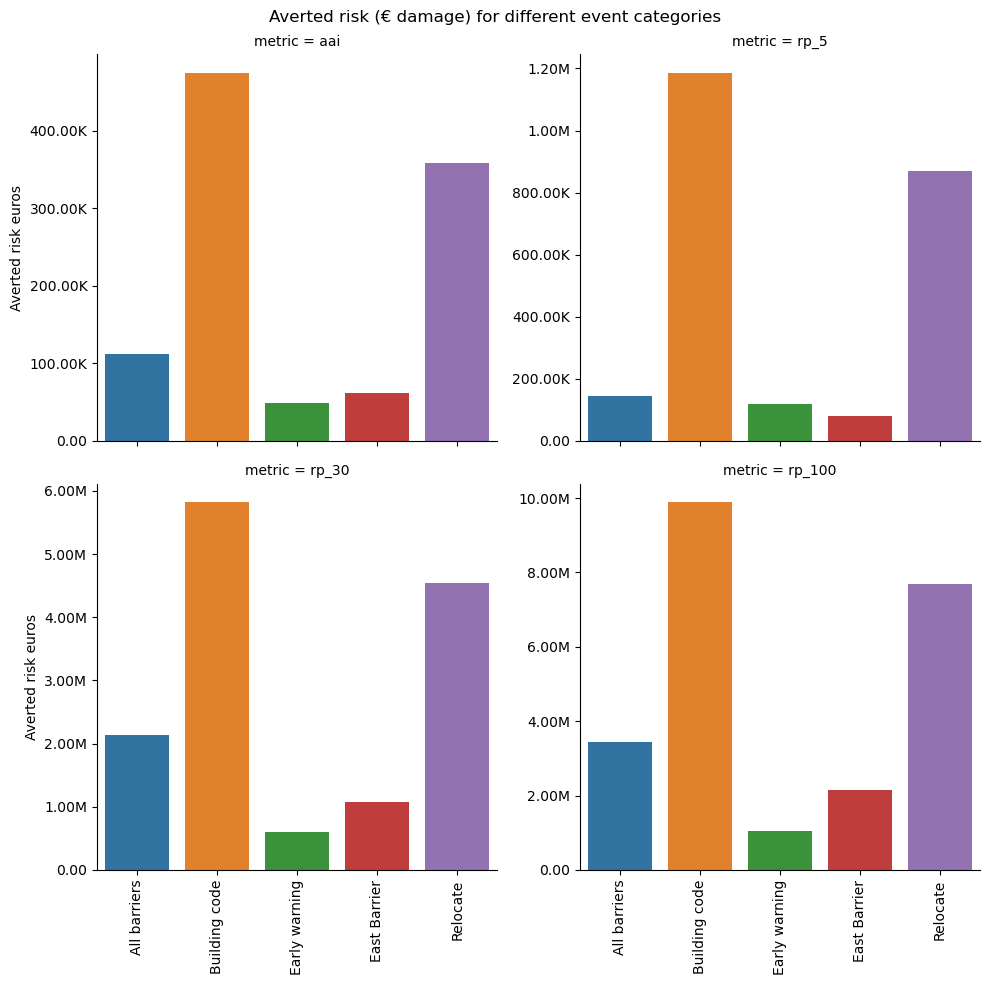

In [52]:
grid = sns.catplot(
    mca.risk_metrics.loc[mca.risk_metrics["group"] == "All"],
    kind="bar",
    x="measure",
    y="averted risk_euros",
    hue="measure",
    col="metric",
    col_order=["aai", "rp_5", "rp_30", "rp_100"],
    col_wrap=2,
    sharey=False,
)
grid.tick_params(axis="x", labelrotation=90)

for ax in grid.axes.flatten():
    ax.yaxis.set_major_formatter(formatter)
    ax.set_xlabel("")

# Iterate through the axes in the first column and set the new label
for ax in grid.axes[::2]:
    ax.set_ylabel(format_labels((ax.get_ylabel())))

plt.suptitle("Averted risk (€ damage) for different event categories")
grid.tight_layout()

In [ ]:
mca.criteria_weights

averted risk_euros           5
averted risk_people          5
cost/benefit ratio_euros     5
cost/benefit ratio_people    5
measure net cost_euros       5
public approval              5
risk_euros                   5
risk_people                  5
Name: criteria weights, dtype: int64

In [9]:
# We can weight everything (defaults to all equally weigthed)
mca.criteria_weights
mca.metrics_weights
mca.groups_weights
mca.weights

group  metric  criteria                 
0      aai     averted risk_euros           0.014952
               averted risk_people          0.014952
               cost/benefit ratio_euros     0.014952
               cost/benefit ratio_people    0.014952
               measure net cost_euros       0.014952
                                              ...   
All    rp_5    cost/benefit ratio_people    0.002990
               measure net cost_euros       0.002990
               public approval              0.002990
               risk_euros                   0.002990
               risk_people                  0.002990
Length: 80, dtype: float64

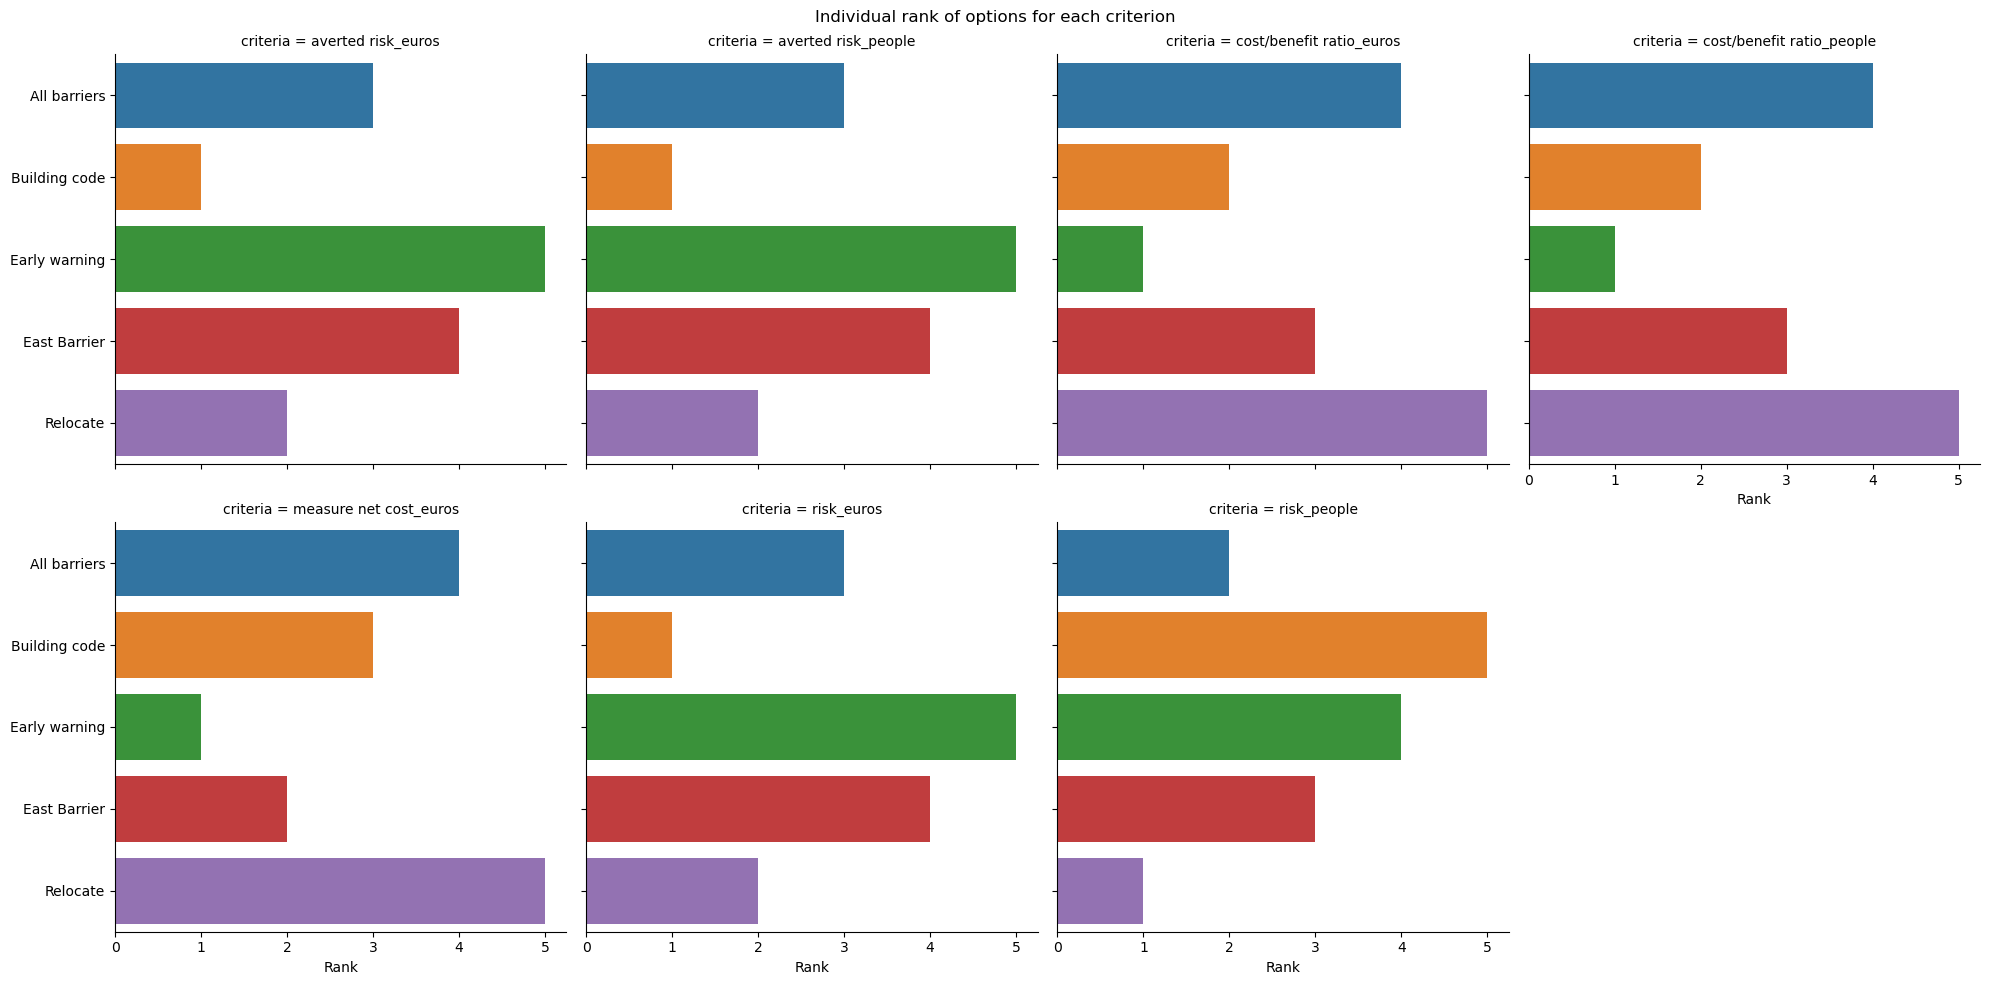

In [77]:
grid = sns.catplot(
    mca.individual_rank(sub_selection={"group": "All", "metric": "aai"})
    .loc[:, ("All", "aai")]
    .stack()
    .reset_index(name="Rank"),
    kind="bar",
    hue="measure",
    y="measure",
    x="Rank",
    col="criteria",
    col_wrap=4,
)

for ax in grid.axes.flatten():
    ax.set_ylabel("")
    # ax.xaxis.set_inverted(True)

plt.suptitle("Individual rank of options for each criterion")
grid.tight_layout()

In [28]:
mca.pivoted_risk_metrics(sub_selection={"group": "All", "metric": ["aii", "rp_30"]})

group                        All                                               \
metric                     rp_30                                                
criteria      averted risk_euros averted risk_people cost/benefit ratio_euros   
measure                                                                         
All barriers        2.128514e+06          162.970732                30.067920   
Building code       5.824758e+06          517.573222                 8.584048   
Early warning       5.926970e+05           50.864758                 0.337441   
East Barrier        1.070095e+06          126.234467                26.913508   
Relocate            4.548727e+06          349.535813              1758.733835   

group                                                           \
metric                                                           
criteria      cost/benefit ratio_people measure net cost_euros   
measure                                                          
All barriers               3.927086e+05           6.400000e+07   
Building code              9.660469e+04           5.000000e+07   
Early warning              3.931995e+03           2.000010e+05   
East Barrier               2.281469e+05           2.880000e+07   
Relocate                   2.288750e+07           8.000000e+09   

group                                                    
metric                                                   
criteria      public approval    risk_euros risk_people  
measure                                                  
All barriers              3.0  3.798456e+06  345.676757  
Building code             5.0  1.022127e+05  508.647489  
Early warning             4.0  5.334273e+06  457.782731  
East Barrier              2.0  4.856876e+06  382.413022  
Relocate                  0.0  1.378243e+06  159.111676

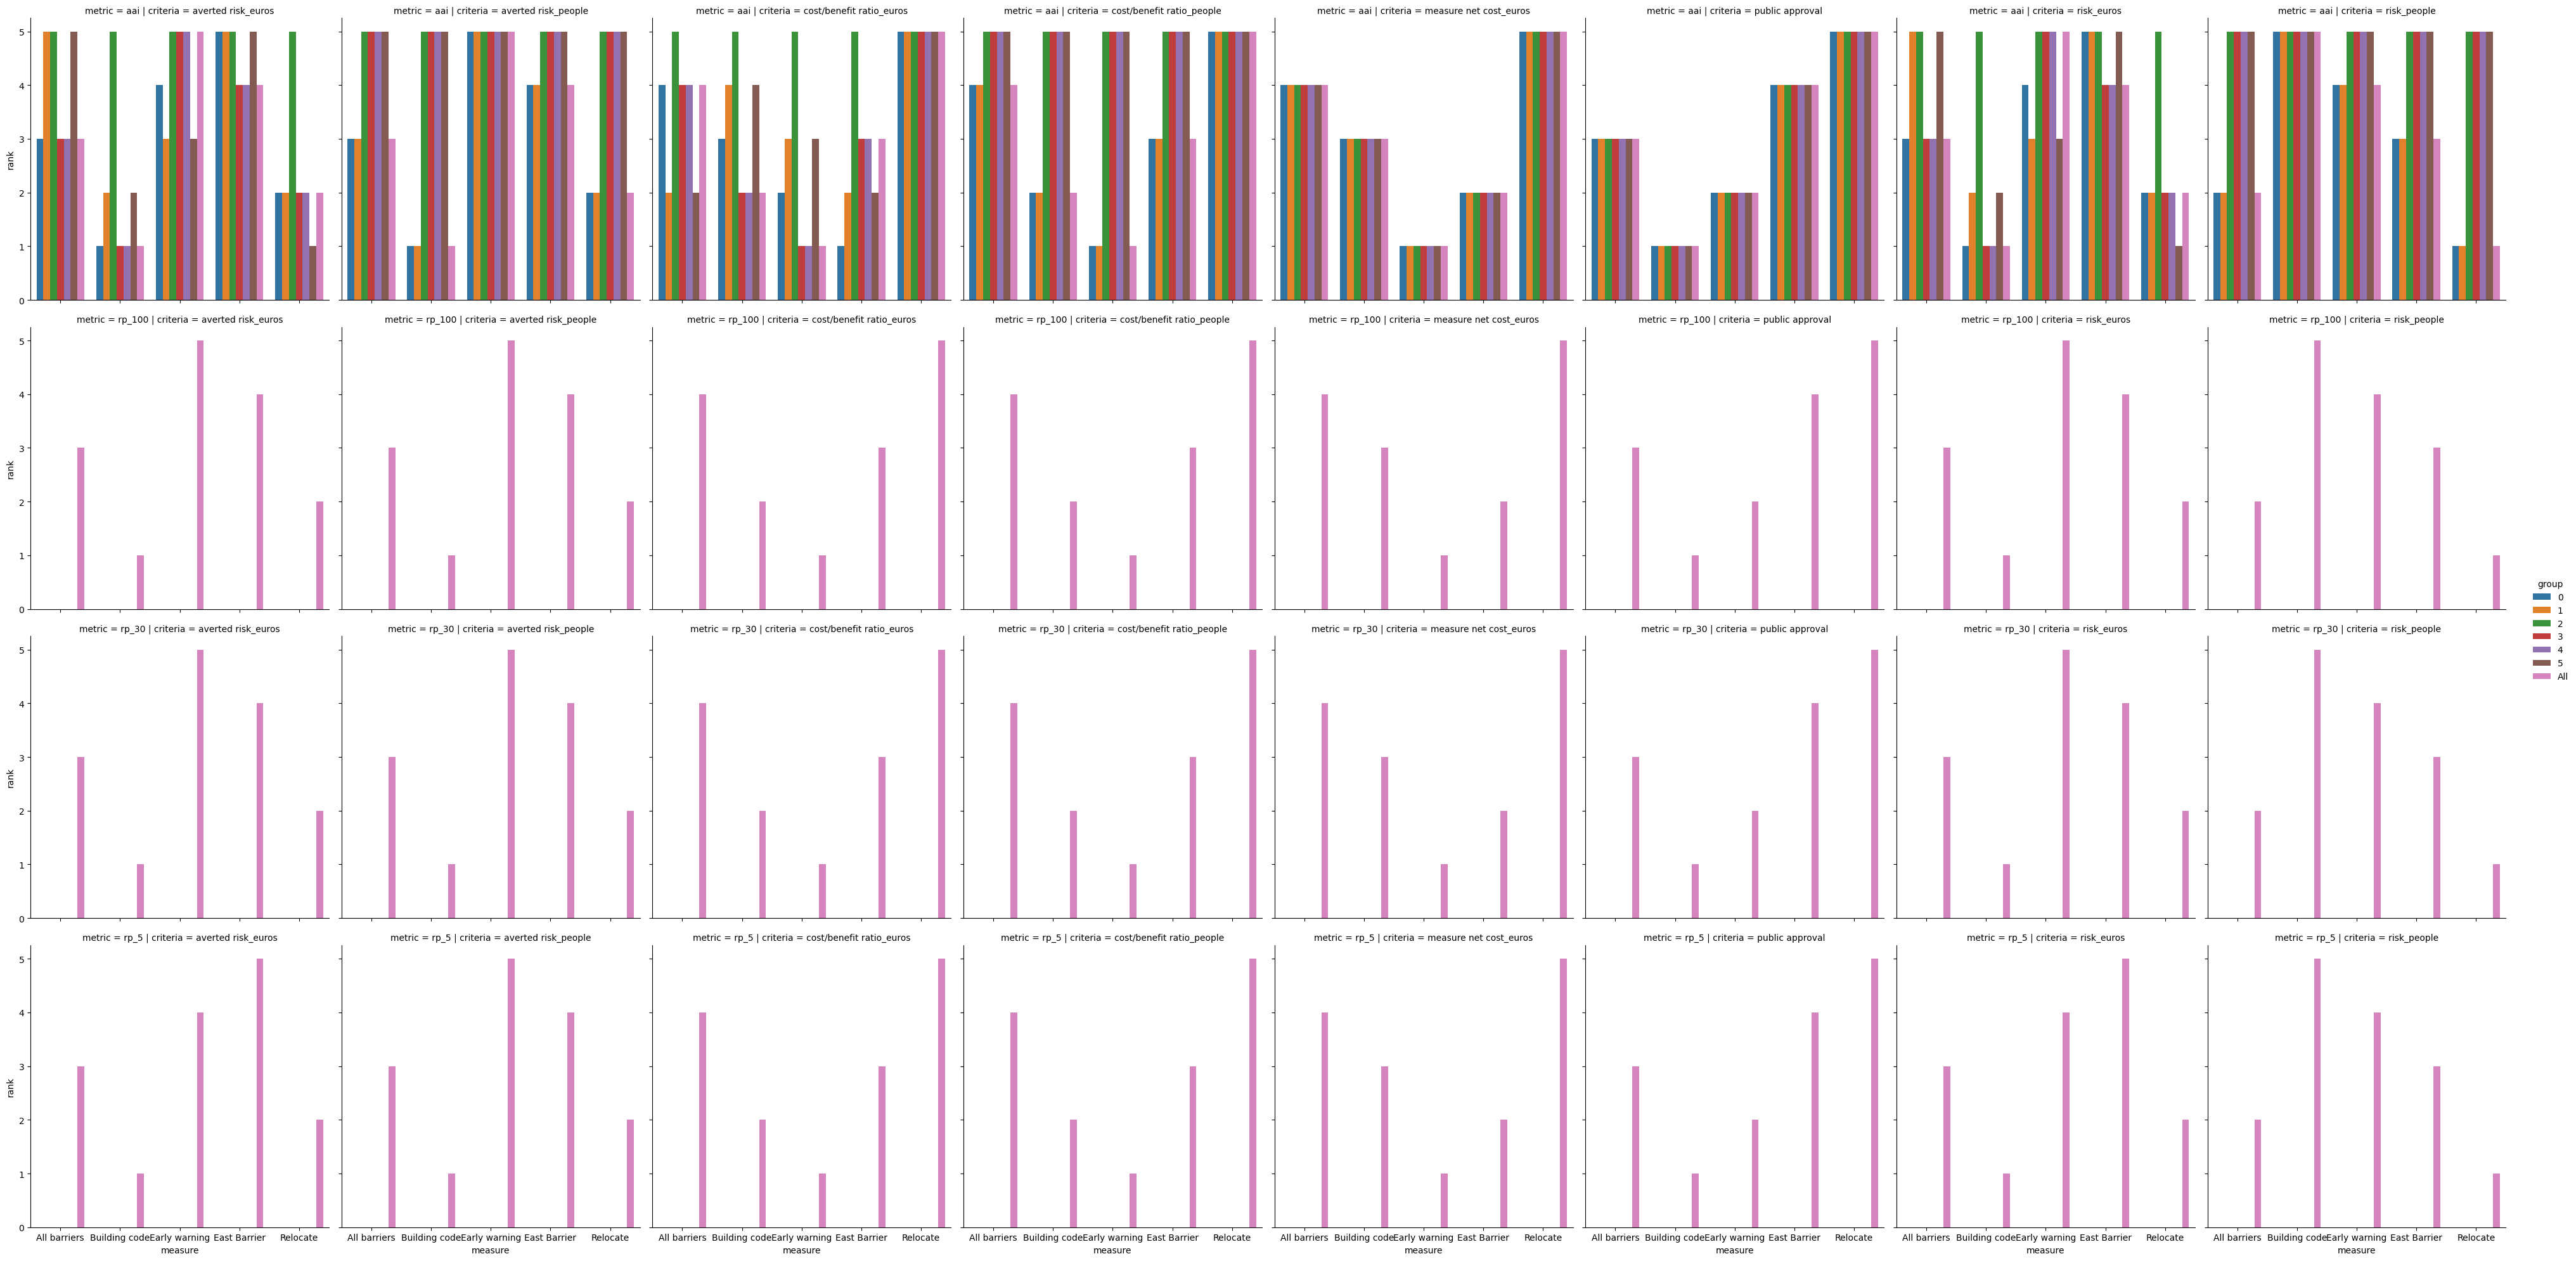

In [16]:
grid = sns.catplot(
    mca.individual_rank().stack().stack().stack().to_frame(name="rank").reset_index(),
    kind="bar",
    hue="group",
    col="criteria",
    row="metric",
    x="measure",
    y="rank",
)

In [84]:
mca.calc_rankings()

/home/sjuhel/miniforge3/envs/climada_MCA/lib/python3.11/site-packages/pyrepo_mcda/normalizations.py:53: RuntimeWarning: invalid value encountered in divide
  x_norm[:, types == 1] = (matrix[:, types == 1] - np.amin(matrix[:, types == 1], axis = 0)
/home/sjuhel/miniforge3/envs/climada_MCA/lib/python3.11/site-packages/pyrepo_mcda/normalizations.py:56: RuntimeWarning: invalid value encountered in divide
  x_norm[:, types == -1] = (np.amax(matrix[:, types == -1], axis = 0) - matrix[:, types == -1]
/home/sjuhel/miniforge3/envs/climada_MCA/lib/python3.11/site-packages/pyrepo_mcda/mcda_methods/vikor.py:72: RuntimeWarning: invalid value encountered in divide
  weighted_matrix = weights * ((fstar - matrix) / (fstar - fmin))


,Topsis,Saw,Vikor,copeland
measure,,,,
All barriers,0,3,0,3
Building code,0,4,0,4
Early warning,0,5,0,5
East Barrier,0,1,0,1
Relocate,0,2,0,2


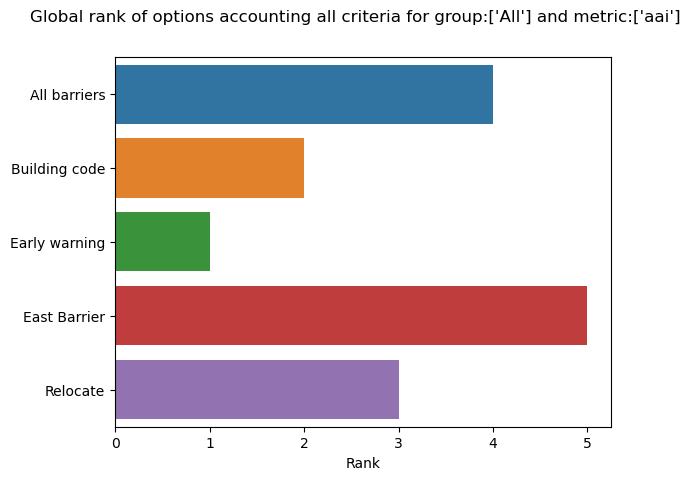

In [85]:
metric = ["aai"]
group = ["All"]
ax = sns.barplot(
    mca.calc_rankings(sub_selection={"group": group, "metric": metric})[["Saw"]],
    hue="measure",
    y="measure",
    x="Saw",
)

ax.set_ylabel("")
ax.set_xlabel("Rank")

plt.suptitle(
    f"Global rank of options accounting all criteria for group:{group} and metric:{metric}"
)
grid.tight_layout()

/home/sjuhel/miniforge3/envs/climada_MCA/lib/python3.11/site-packages/pyrepo_mcda/normalizations.py:53: RuntimeWarning: invalid value encountered in divide
  x_norm[:, types == 1] = (matrix[:, types == 1] - np.amin(matrix[:, types == 1], axis = 0)
/home/sjuhel/miniforge3/envs/climada_MCA/lib/python3.11/site-packages/pyrepo_mcda/normalizations.py:56: RuntimeWarning: invalid value encountered in divide
  x_norm[:, types == -1] = (np.amax(matrix[:, types == -1], axis = 0) - matrix[:, types == -1]
/home/sjuhel/miniforge3/envs/climada_MCA/lib/python3.11/site-packages/pyrepo_mcda/mcda_methods/vikor.py:72: RuntimeWarning: invalid value encountered in divide
  weighted_matrix = weights * ((fstar - matrix) / (fstar - fmin))


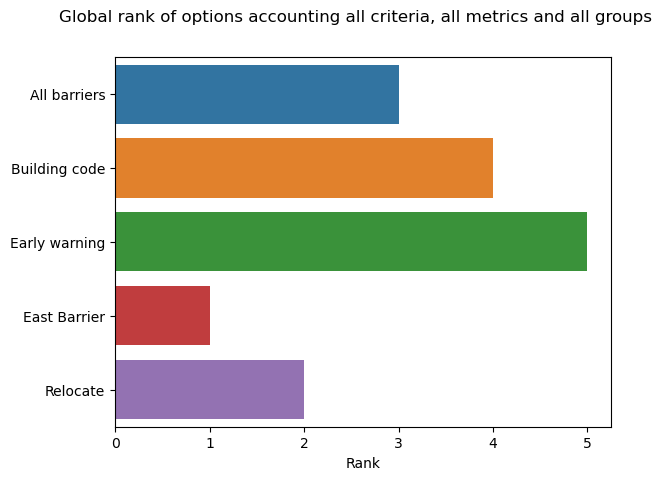

In [86]:
ax = sns.barplot(
    mca.calc_rankings()[["Saw"]],
    hue="measure",
    y="measure",
    x="Saw",
)

ax.set_ylabel("")
ax.set_xlabel("Rank")

plt.suptitle(
    f"Global rank of options accounting all criteria, all metrics and all groups"
)
grid.tight_layout()

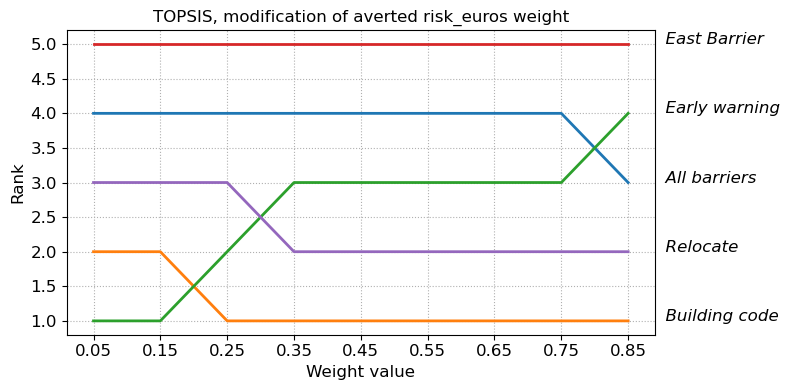

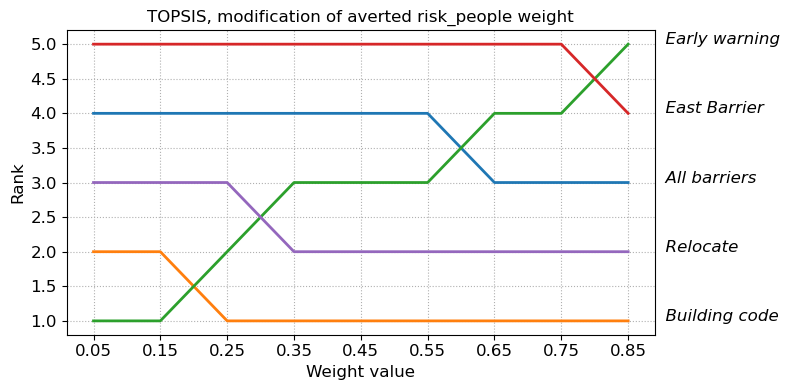

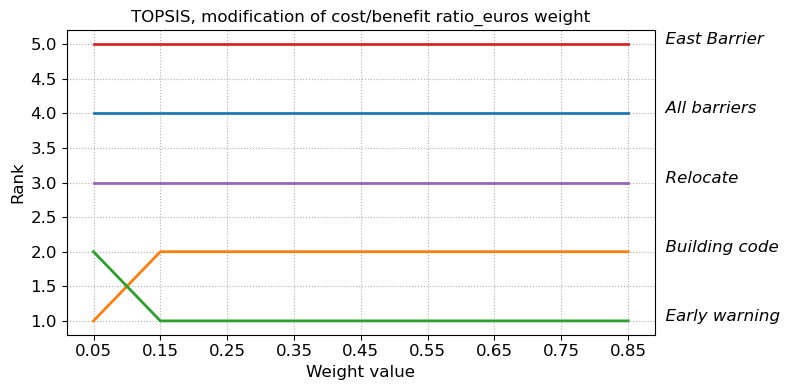

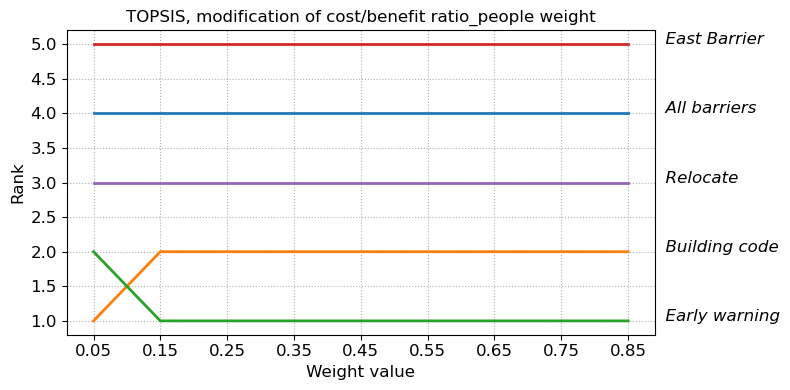

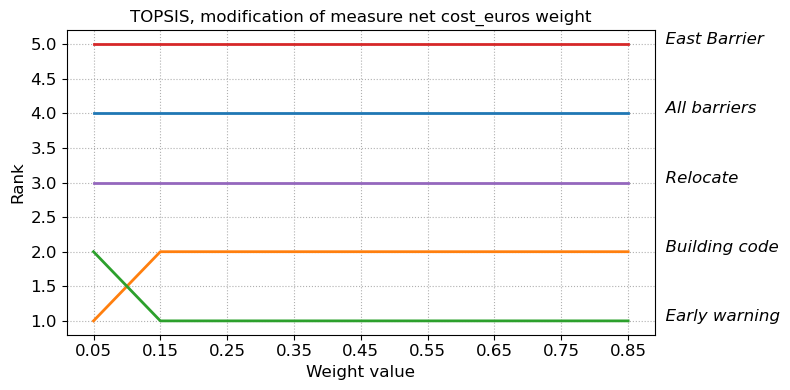

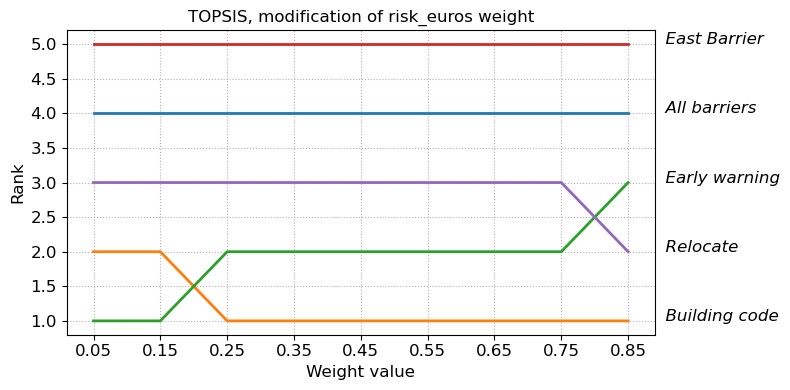

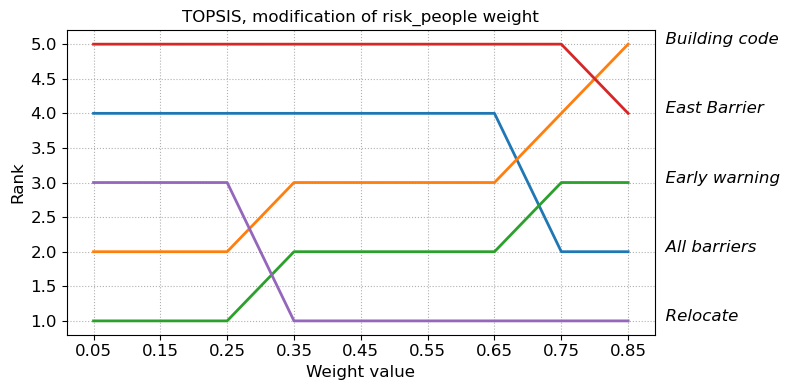

In [88]:
mca.plot_weight_sensitivity(method=SAW())

## Add custom criteria

In [18]:
# Same, the following will probably change, but was easier to manipulate than victor's code.
mca = MCA_Calc(
    risk_metrics=df,
    metrics_col="metric",
    groups_col="group",
    criteria=criteria,
    groups_weights={"0": 5, "1": 5, "2": 1, "3": 1, "4": 1, "5": 1, "All": 5},
    metrics_weights={
        "aai": 5,
        "rp_5": 1,
        "rp_30": 2,
        "rp_100": 3,
    },
    criteria_weights={
        "measure net cost_euros": 5,
        "averted risk_euros": 5,
        "averted risk_people": 5,
        "cost/benefit ratio_euros": 5,
        "cost/benefit ratio_people": 5,
        "risk_euros": 5,
        "risk_people": 5,
    },
    #    constraints = ["`measure net cost` > 10"]
)

In [19]:
df["measure"].unique()
custom_criteria = {"public approval": ([3, 5, 4, 2, 0], 5)}

for name, (value, weight) in custom_criteria.items():
    new_crit_val = pd.Series(
        {k: v for k, v in zip(mca.options_names, value)}, name=name
    )
    new_crit = Criterion(name=name, column_name=name, obj_maximise=True)
    mca.add_criterion(new_crit, new_crit_val, weight)